# 루브릭
|평가문항|상세기준|self check|
|:-------|:-------|:-----------------------|
|1. 1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.|오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.|OK|
|2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.|gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.|OK|
|3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.|모델구조 변경 혹은 학습과정 개선 아이디어를 추가적으로 적용해보았고, 적용 전과 비교하였을 때의 내용을 표와 같은 시각적 자료로 작성하였다.|OK|

### dataset
1. CIFAR-10
  * dog

### 적용할 알고리즘
1. DCGAN(Deep Convolutional Generative Adversarial Networks)


## 문제 정의  

> DCGAN 모델구조로 CIFAR-10 데이터 생성하기


## 분석환경

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)
print('imageio',imageio.__version__)

tensorflow 2.6.0
imageio 2.9.0


## STEP 1. 작업환경 구성하기

In [44]:
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

## STEP 2. 데이터셋 구성하기

* 학습에 사용할 train_x의 이미지를 -1, 1로 정규화
* 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
* tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋 구성

In [3]:
#cifar10 = tf.keras.datasets.cifar10
#(train_x, _), (test_x, _) = cifar10.load_data()
#train_x.shape

* dog 데이터만 추출해 진행

In [4]:
import pandas as pd

def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

# 5 : dog
train_x, test_x  = load_data(label=5)

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(5000, 32, 32, 3)

In [5]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [6]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [7]:
train_x.shape

(5000, 32, 32, 3)

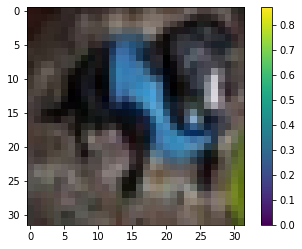

In [8]:
#plt.imshow(train_x[0])
plt.imshow((train_x[0]+1)/2)
plt.colorbar()
plt.show()

<Figure size 720x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'index: 0')

(-0.5, 31.5, 31.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'index: 1')

(-0.5, 31.5, 31.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'index: 2')

(-0.5, 31.5, 31.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'index: 3')

(-0.5, 31.5, 31.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'index: 4')

(-0.5, 31.5, 31.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'index: 5')

(-0.5, 31.5, 31.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'index: 6')

(-0.5, 31.5, 31.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'index: 7')

(-0.5, 31.5, 31.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'index: 8')

(-0.5, 31.5, 31.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'index: 9')

(-0.5, 31.5, 31.5, -0.5)

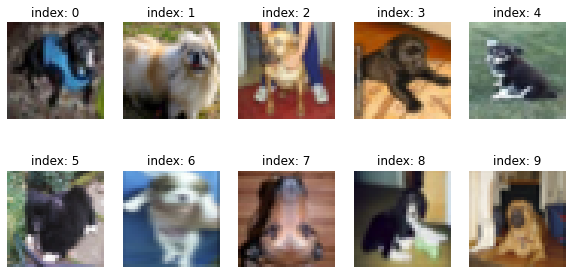

In [11]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i]+1)/2)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

* 미니배치 데이터셋구성

In [13]:
#BUFFER_SIZE = 50000
#BATCH_SIZE = 256

BUFFER_SIZE = 5000
BATCH_SIZE = 128

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 3. 생성자 모델 구현하기

* (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성
* noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지 생성
* 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

* 생성자(Generator)

In [79]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [80]:
generator = make_generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)        

* random noise vector 생성

In [23]:
noise = tf.random.normal((1,100))
noise.shape

TensorShape([1, 100])

In [24]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

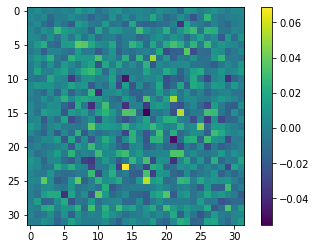

In [25]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## STEP 4. 판별자 모델 구현하기

* (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수 작성
* 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값 확인

* 판별자(Discriminator)

In [26]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [27]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [28]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00346681]], dtype=float32)>

## STEP 5. 손실함수와 최적화 함수 구현하기

* 생성자와 판별자의 손실함수(loss) 구현
* 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수 구현.
* 생성자와 판별자를 최적화하는 optimizer 정의

### 5.1 손실함수(loss)

In [29]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

* generator_loss

In [30]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

* discriminator_loss

In [31]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

* discriminator_accuracy

In [33]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 5-2 최적화 함수(optinizer)

In [34]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 5-3 sample 생성

In [35]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 6. 훈련과정 상세 기능 구현하기

* 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수 구현
* 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수
* 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현
* training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈 설정

In [36]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [65]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    print(predictions.shape)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.imshow((predictions[i]+1)/2)
        
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [38]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [39]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행하기

* 최소 50 epoch만큼의 모델 학습을 진행
* 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현
* 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출

* checkpoint 모듈을 활용하여 모델 로드

(1, 32, 32, 3)

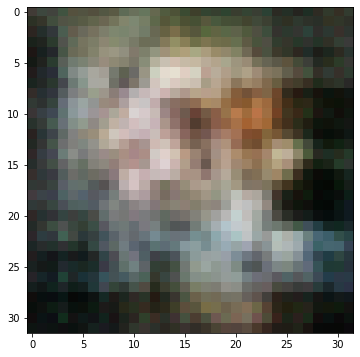

In [75]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
np_generated.shape
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [41]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [76]:
save_every = 5
#EPOCHS = 50
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

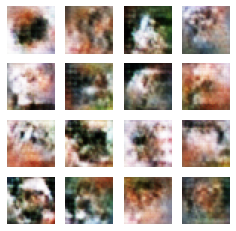

Time for training : 1627 sec


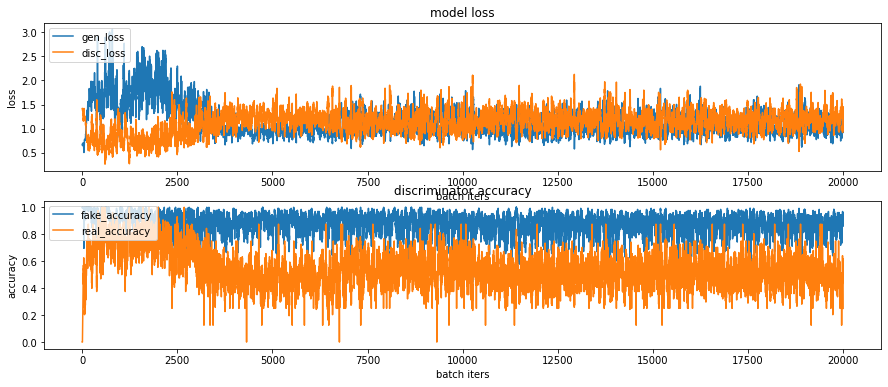

CPU times: user 29min 25s, sys: 4min 33s, total: 33min 58s
Wall time: 27min 9s


In [44]:
%%time
train(train_dataset, EPOCHS, save_every)

(16, 32, 32, 3)


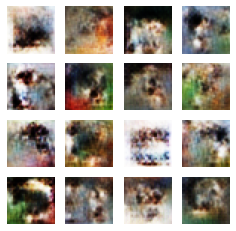

Time for training : 1656 sec


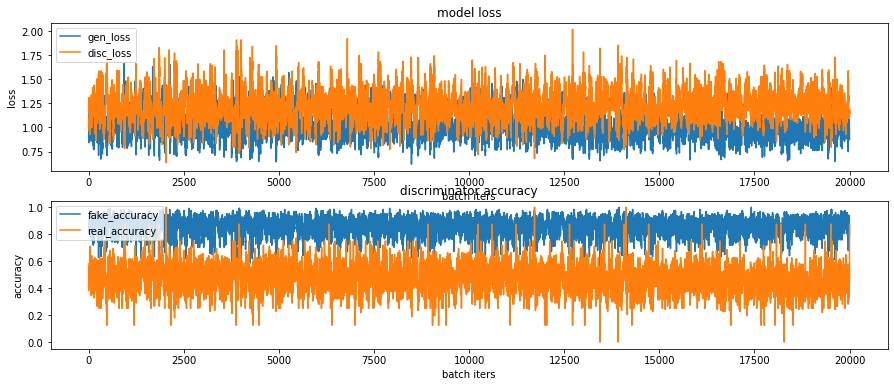

CPU times: user 29min 54s, sys: 4min 37s, total: 34min 32s
Wall time: 27min 38s


In [77]:
%%time
train(train_dataset, EPOCHS, save_every)

* 학습과정 시각화하기(GIF 파일)

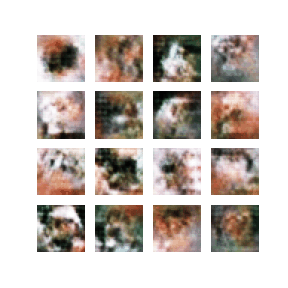

In [78]:
#anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dogs_dcgan.gif'
anim_file = './cifar10_dogs_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

#!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dogs_dcgan.gif

Image(filename='./cifar10_dogs_dcgan.gif') 

## STEP 8. (optional) GAN 훈련 과정 개선하기